In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Generate synthetic data
np.random.seed(42)
import seaborn as sns
from tqdm.auto import tqdm


/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from nuclearpy_models.models.rc import sr_rc, mnp_rc
import sys
sys.path.append('../../nuclearpy_models')
from models.rc import sr_rc, mnp_rc

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize.minpack as minpack
from scipy.optimize import curve_fit


In [4]:
df = pd.read_csv('../../Data/Experimental/rc_train.csv')
# replace the points with delta_Rav = 0 with 1e-7
df['delta_Rav'] = df['delta_Rav'].replace(0., 1e-7)

In [5]:
def resample_data(df):
    fdf = df.copy()
    observable = df.Rav
    experimental_uncertainty = df.delta_Rav
    # sample from a normal distribution with the mean and standard deviation of the experimental uncertainty
    fdf.Rav = np.random.normal(observable, experimental_uncertainty)
    return fdf

In [6]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd

def resample_data(df):
    fdf = df.copy()
    observable = df['Rav'].values
    experimental_uncertainty = df['delta_Rav'].values
    # Ensure sampling for each data point
    fdf['Rav'] = np.random.normal(observable, experimental_uncertainty)
    return fdf

def parametrized_sum(ZN, *weights):
    preds = []
    Zs, Ns = ZN
    for Z, N in zip(Zs, Ns):
        preds_per_term = [sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)]
        preds.append(np.dot(weights, preds_per_term))
    return preds

def bayesian_fit(data, N_ITERATIONS=100):
    data['Rav'] = data['Rav'].astype(float)
    data['delta_Rav'] = data['delta_Rav'].astype(float)

    optimal_parameters = []
    parameter_covariances = []  # Store covariance matrices
    rmses = []

    for _ in tqdm(range(N_ITERATIONS)):
        # Bootstrap resampling: Sample with replacement
        fdf = data.sample(n=int(0.8*len(data)), replace=True).query("Z<50")

        # Resample the data (perturb based on uncertainty)
        fdf = resample_data(fdf)

        target = fdf["Rav"].values
        X = fdf[["Z", "N"]].values
        p0 = np.ones(sr_rc.max_index)

        ZN_data = X.T  # Transpose to shape (n_samples, n_features)
        params_opt, params_cov = curve_fit(parametrized_sum, ZN_data, target, p0=p0)

        optimal_parameters.append(params_opt)
        parameter_covariances.append(params_cov)  # Store the covariance matrix

        # Predict
        preds = parametrized_sum(ZN_data, *params_opt)
        rmse = mean_squared_error(target, preds, squared=False)
        rmses.append(rmse)

    return optimal_parameters, parameter_covariances, rmses


In [7]:
optimal_parameters, parameter_covariances, rmses = bayesian_fit(df, N_ITERATIONS = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [8]:
num_weights = sr_rc.max_index
means = []
stds = []

optimal_parameters = np.array(optimal_parameters)
stds = np.sqrt(np.diagonal(np.array(parameter_covariances), axis1=1, axis2=2))

means = np.mean(optimal_parameters, axis=0)
stds = np.mean(stds, axis=0)

Some plots to show the distribution of the data and the correlation between the features.

# histograms of the distribution of the weights

Weight 0: 1.00 +/- 0.00
Weight 1: 1.04 +/- 0.11
Weight 2: -0.12 +/- 0.10
Weight 3: -0.19 +/- 0.48
Weight 4: 0.97 +/- 0.27
Weight 5: 1.38 +/- 0.32
Weight 6: 0.81 +/- 0.32
Weight 7: 1.50 +/- 0.50


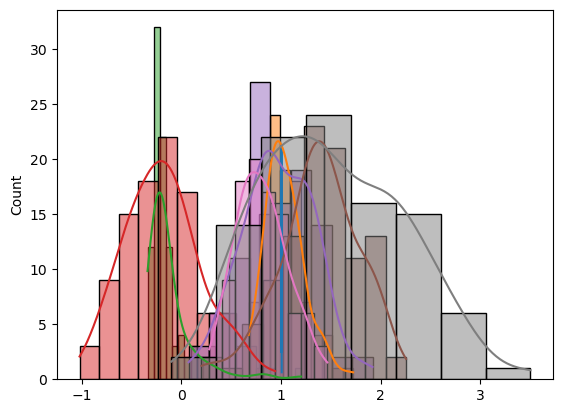

In [9]:
for i in range(num_weights):
    print(f"Weight {i}: {means[i]:.2f} +/- {stds[i]:.2f}")
    sns.histplot(optimal_parameters[:, i], kde=True)

Inference with uncertainty

In [10]:
def predict_with_uncertainty_boostrapping(Z, N, means=means, stds=stds, num_samples=1000): # This method is incorrect
    weights = np.random.normal(means, stds, size=(num_samples, len(means)))
    preds_per_term = np.array([sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)])
    preds = np.dot(weights, preds_per_term.T)
    return np.mean(preds), np.std(preds)

def predict_with_propagation(Z, N, means=means, stds=stds):
    preds_per_term = np.array([sr_rc.predict_single_term(Z, N, i) for i in range(sr_rc.max_index)])
    preds = np.dot(means, preds_per_term)
    std = np.sqrt(np.dot(preds_per_term**2, stds**2))
    return preds, std

In [11]:
predict_with_propagation(20, 20), predict_with_uncertainty_boostrapping(20, 20)

((3.480176000490036, 0.006425558294932008),
 (3.480321697242113, 0.0064325183926932095))

In [12]:
df["pred_sr_rc"] = df.apply(lambda x: predict_with_propagation(x.Z, x.N)[0], axis=1)
df["pred_sr_unc"] = df.apply(lambda x: predict_with_propagation(x.Z, x.N)[1], axis=1)

In [13]:

def plot_range(Z, n_ref, n_min, n_max,  index=-1):
    fig, ax = plt.subplots(figsize=(10, 8))
    n = np.arange(n_min, n_max+1)
    plt.errorbar(df.query(f"Z=={Z}")["N"], df.query(f"Z=={Z}")["Rav"], yerr=df.query(f"Z=={Z}")["delta_Rav"], fmt='o', label="exp", color="black")
    sns.lineplot(x=df.query(f"Z=={Z}")["N"], y=df.query(f"Z=={Z}")["Rav"], color="black")

    preds_sr = [predict_with_propagation(Z, n) for n in n]
    center = [p[0] for p in preds_sr]
    uncertainty = [p[1] for p in preds_sr]
    plt.errorbar(n, center, yerr=uncertainty, fmt='o', color="blue", label=f"MISR({index})")
    # Fill the area between the predicted values and the uncertainty
    plt.fill_between(n, np.array(center) - np.array(uncertainty), np.array(center) + np.array(uncertainty), alpha=0.2, color="blue")

    preds_mnp = [mnp_rc(Z, n) for n in n]
    plt.plot(n, preds_mnp, color="grey", alpha=0.5)
    plt.scatter(n, preds_mnp,  label="Nerlo-Pomorska",color="grey", s=10)
    # ax.set(xlim=(n_min, n_max), ylim=(3.41, 3.55) )
    plt.xlabel("N")
    plt.ylabel(r"$\langle r_{\mathrm{av}}\rangle$ [fm]")
    plt.legend(loc="lower right")


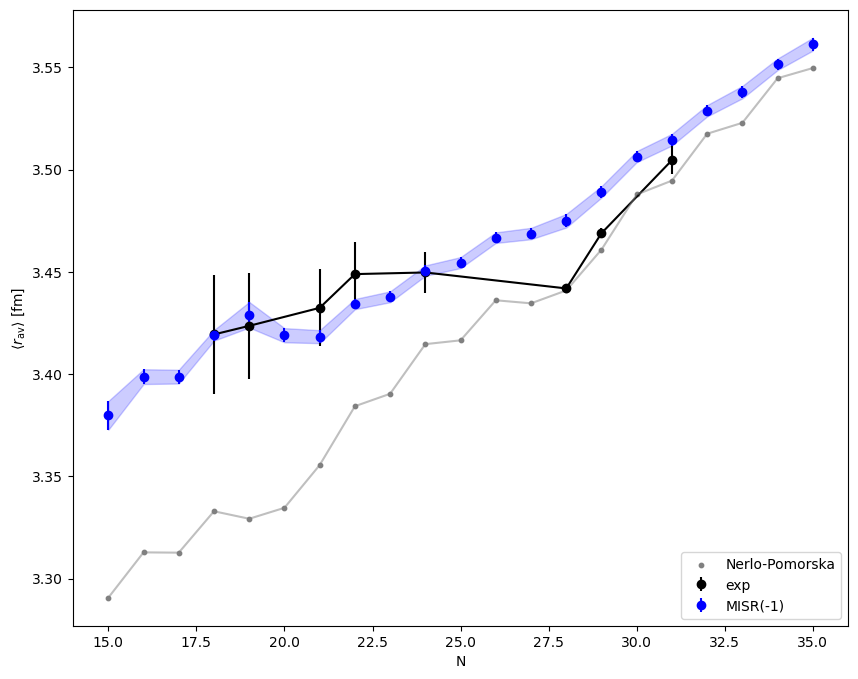

In [14]:
Z = 19
n_min, n_max = 15, 35
n_ref = 28
plot_range(Z, n_ref, n_min, n_max, index=-1)

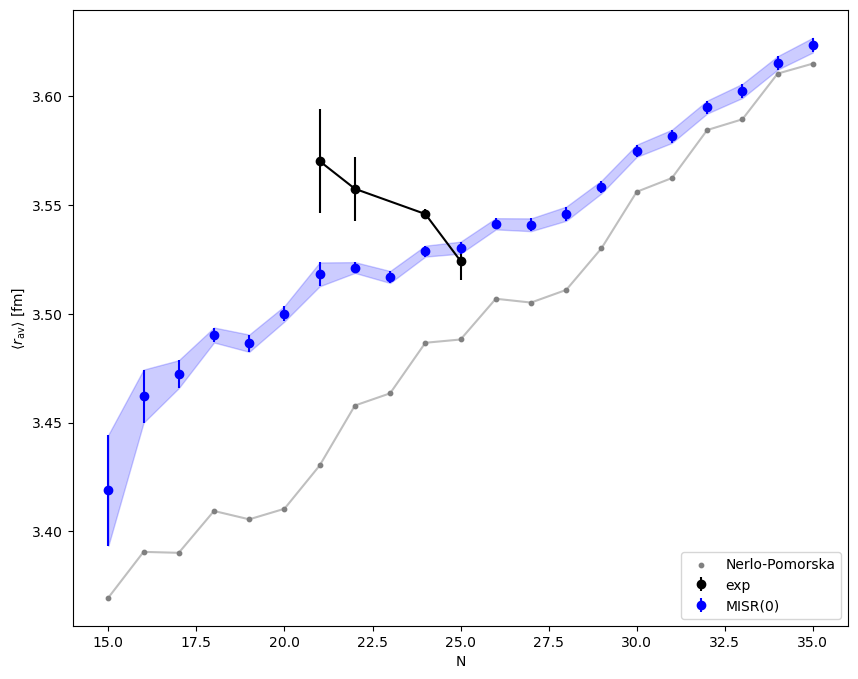

In [15]:
plot_range(21, n_ref, n_min, n_max, index=0)